In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from random import random

# Coin

In [2]:
def prior(p):
    return dist.Uniform(0,1, validate_args=False).log_prob(p).exp()

def likelihood(xs,p):
    lp = torch.tensor(0.)
    for x in xs:
        lp += dist.Bernoulli(p, validate_args=False).log_prob(x)
    return lp.exp()

def joint(xs, p):
    return prior(p) * likelihood(xs, p)

In [3]:
xs = torch.tensor([0.,1.,1.,0.,0.])
posterior = dist.Beta(1 + xs.sum(), 1 + (1-xs).sum())

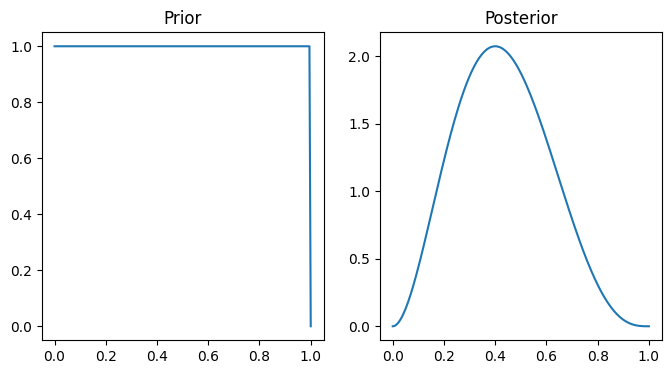

In [4]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ps = torch.linspace(0,1,200)
prior_vals = torch.hstack([prior(p) for p in ps])

posterior_unnormalised = torch.hstack([joint(xs, p) for p in ps])
marginal = torch.trapz(posterior_unnormalised, ps)
posterior = posterior_unnormalised / marginal
axs[0].plot(ps, prior_vals)
axs[0].set_title("Prior")
axs[1].plot(ps, posterior)
axs[1].set_title("Posterior")
plt.savefig("lecture_2_figs/coin.png")

### Frequentist Methods

#### Maximum Likelihood Estimator

In [5]:
ps = torch.linspace(0,1,10000)
l = torch.hstack([likelihood(xs, p) for p in ps])
ps[l.argmax()]

tensor(0.3999)

#### Hypothesis Testing

In [6]:
torch.manual_seed(0)
means = dist.Bernoulli(0.5).sample((len(xs), 10000)).mean(dim=0)
m = xs.mean()
a = min(1-m,m)
b = max(1-m,m)
((means < a) | (b < means)).float().mean()

tensor(0.3662)

# Probabilistic Programming Languages

In [7]:
def linear_regression(x,y):
    lp = torch.tensor(0.0)
    
    slope = dist.Normal(0.,3.).sample()
    lp += dist.Normal(0.,3.).log_prob(slope)
    
    intercept = dist.Normal(0.,3.).sample()
    lp += dist.Normal(0.,3.).log_prob(intercept)
    
    sigma = dist.HalfCauchy(1).sample()
    lp += dist.HalfCauchy(1).log_prob(sigma)
    
    for i in range(len(x)):
        lp += dist.Normal(slope * x[i] + intercept, sigma).log_prob(y[i])
    
    
    return (slope, intercept, sigma), lp

In [8]:
x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = torch.tensor([-1.2, -1.5, 0.0, -0.8, 1.5])

In [9]:
(slope, intercept, sigma), lp = linear_regression(x,y)
(slope, intercept, sigma), lp

((tensor(-2.0165), tensor(-6.8393), tensor(1.2225)), tensor(-92.6320))

In [10]:
def linear_regression_lp(slope, intercept, sigma, x, y):
    lp = torch.tensor(0.0)
    
    lp += dist.Normal(0.,3.).log_prob(slope)
    
    lp += dist.Normal(0.,3.).log_prob(intercept)
    
    lp += dist.HalfCauchy(1).log_prob(sigma)
    
    for i in range(len(x)):
        lp += dist.Normal(slope * x[i] + intercept, sigma).log_prob(y[i])
    
    return lp

In [11]:
linear_regression_lp(slope, intercept, sigma, x, y)

tensor(-92.6320)

# A Minimal PPL

In [12]:
import torch
from typing import Optional
from abc import ABC, abstractmethod

_SAMPLE_CONTEXT = None

class SampleContext(ABC):
    def __enter__(self):
        global _SAMPLE_CONTEXT
        _SAMPLE_CONTEXT = self

    def __exit__(self, *args):
        global _SAMPLE_CONTEXT
        _SAMPLE_CONTEXT = None

    @abstractmethod
    def sample(self,
               address: str,
               distribution: dist.Distribution,
               observed: Optional[torch.Tensor] = None) -> torch.Tensor:
        raise NotImplementedError

In [13]:
def sample(address: str,
           distribution: dist.Distribution,
           observed: Optional[torch.Tensor] = None) -> torch.Tensor:
    global _SAMPLE_CONTEXT
    
    # default behavior
    if _SAMPLE_CONTEXT is None:
        if observed is not None:
            return observed
        return distribution.sample()
    
    # context specific behavior
    return _SAMPLE_CONTEXT.sample(address, distribution, observed)

In [14]:
def noisy_geometric(p):
    x = 0
    while True:
        b = sample(f"b_{x}", dist.Bernoulli(p))
        if b:
            break
        x += 1
    y = sample("y", dist.Normal(x,1), observed=torch.tensor(3.))
    return x

In [15]:
torch.manual_seed(0)
[noisy_geometric(0.25) for _ in range(10)]

[2, 0, 8, 0, 4, 8, 0, 3, 1, 0]

In [16]:
class LogProb(SampleContext):
    def __init__(self, trace):
        self.log_prob = torch.tensor(0.)
        self.trace = trace

    def sample(self,
               address: str,
               distribution: dist.Distribution,
               observed: Optional[torch.Tensor] = None) -> torch.Tensor:
               
        if observed is not None:
            value = observed
        else:
            value = self.trace[address]
            
        self.log_prob += distribution.log_prob(value)
        
        return value

In [17]:
torch.manual_seed(0)
ctx = LogProb({"b_0": torch.tensor(0.), "b_1": torch.tensor(0.), "b_2": torch.tensor(1.)})
with ctx:
    x = noisy_geometric(0.25)
x, ctx.log_prob

(2, tensor(-3.3806))

In [18]:
p = torch.tensor(0.25)
2*torch.log(1-p) + torch.log(p) + dist.Normal(2,1).log_prob(torch.tensor(3.))

tensor(-3.3806)

In [19]:
class Trace(SampleContext):
    def __init__(self):
        self.trace = {}

    def sample(self,
               address: str,
               distribution: dist.Distribution,
               observed: Optional[torch.Tensor] = None) -> torch.Tensor:
               
        if observed is not None:
            value = observed
        else:
            value = distribution.sample()
            
        self.trace[address] = {
            'value': value,
            'distribution': distribution,
            'is_observed': observed is not None,
            'log_prob': distribution.log_prob(value)
        }
        
        return value

In [20]:
torch.manual_seed(0)
ctx = Trace()
with ctx:
    x = noisy_geometric(0.25)
ctx.trace

{'b_0': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_1': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_2': {'value': tensor(1.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-1.3863)},
 'y': {'value': tensor(3.),
  'distribution': Normal(loc: 2.0, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-1.4189)}}

In [21]:
def cluster(x):
    K = 2 # 2 clusters
    p =  sample("p", dist.Uniform(0.,1)) # probability of being in cluster 1
    mu_x = []
    mu_y = []
    sigmas = []
    for k in range(K):
        # Cluster centers
        mu_x.append(sample(f"mu_x_{k}", dist.Uniform(-3,3)))
        mu_y.append(sample(f"mu_y_{k}", dist.Uniform(-3,3)))
        # Cluster spread
        sigmas.append(sample(f"sigma_{k}", dist.HalfCauchy(1)))
    for i in range(len(x)):
        z = sample(f"z_{i}", dist.Bernoulli(p)) # Cluster membership
        mu = torch.hstack([mu_x[0],mu_y[0]]) if z == 1  else torch.hstack([mu_x[1],mu_y[1]])
        sigma = sigmas[0] if z == 1 else sigmas[1]
        sample(f"x_{i}", dist.Normal(mu, sigma), observed=x[i]) # Observed data

In [22]:
torch.manual_seed(0)
ctx = Trace()
with ctx:
    x = cluster(torch.tensor([[0., 0.]]))
ctx.trace 

{'p': {'value': tensor(0.4963),
  'distribution': Uniform(low: 0.0, high: 1.0),
  'is_observed': False,
  'log_prob': tensor(0.)},
 'mu_x_0': {'value': tensor(1.6093),
  'distribution': Uniform(low: -3.0, high: 3.0),
  'is_observed': False,
  'log_prob': tensor(-1.7918)},
 'mu_y_0': {'value': tensor(-2.4691),
  'distribution': Uniform(low: -3.0, high: 3.0),
  'is_observed': False,
  'log_prob': tensor(-1.7918)},
 'sigma_0': {'value': tensor(5.6004),
  'distribution': HalfCauchy(),
  'is_observed': False,
  'log_prob': tensor(-3.9286)},
 'mu_x_1': {'value': tensor(0.8045),
  'distribution': Uniform(low: -3.0, high: 3.0),
  'is_observed': False,
  'log_prob': tensor(-1.7918)},
 'mu_y_1': {'value': tensor(-0.0594),
  'distribution': Uniform(low: -3.0, high: 3.0),
  'is_observed': False,
  'log_prob': tensor(-1.7918)},
 'sigma_1': {'value': tensor(1.6722),
  'distribution': HalfCauchy(),
  'is_observed': False,
  'log_prob': tensor(-1.7856)},
 'z_0': {'value': tensor(0.),
  'distribution':

# Coin Model
## Rejection Sampling

In [23]:
def rejection_sampling(xs_observed):
    i = 0
    while True:
        i += 1
        p = dist.Uniform(0,1).sample()
        xs = dist.Bernoulli(p).sample(xs_observed.shape)
        if (xs == xs_observed).all():
            return i, p

In [24]:
torch.manual_seed(0.)
xs = torch.tensor([0.,1.,1.,0.,0.])
posterior = dist.Beta(1 + xs.sum(), 1 + (1-xs).sum())

for i in range(len(xs)):
    xs_observed = xs[:(i+1)]
    N = 1000
    res = [rejection_sampling(xs_observed) for _ in range(N)]
    rejected = sum(i-1 for i,p in res)
    print(f"Rejected {rejected / (N+rejected)*100:.2f}% for {i+1} number of observations.")

Rejected 50.54% for 1 number of observations.
Rejected 83.78% for 2 number of observations.
Rejected 91.76% for 3 number of observations.
Rejected 96.68% for 4 number of observations.
Rejected 98.26% for 5 number of observations.


In [25]:
def prior(p):
    return dist.Uniform(0,1, validate_args=False).log_prob(p).exp()

def likelihood(xs,p):
    lp = torch.tensor(0.)
    for x in xs:
        lp += dist.Bernoulli(p, validate_args=False).log_prob(x)
    return lp.exp()

def joint(xs, p):
    return prior(p) * likelihood(xs, p)

In [26]:
xs = torch.tensor([0.,1.,1.,0.,0.])
posterior = dist.Beta(1 + xs.sum(), 1 + (1-xs).sum())

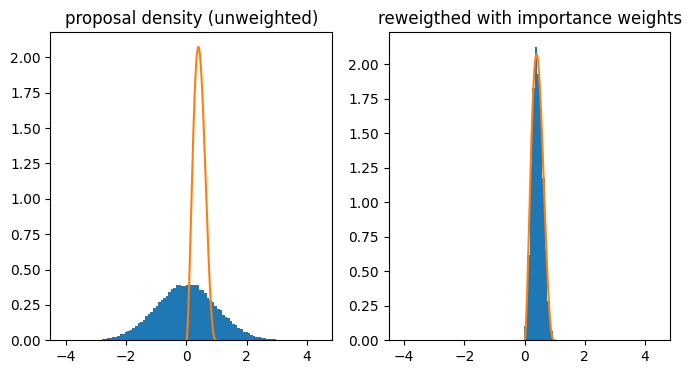

In [27]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
N = 100000
proposal = dist.Normal(0,1)
proposal_sample = proposal.sample((N,))
ps = torch.linspace(0,1,200)
axs[0].hist(proposal_sample, density=True, bins=100)
axs[0].plot(ps, posterior.log_prob(ps).exp())
axs[0].set_title("proposal density (unweighted)")

weights = (
    torch.hstack([joint(xs, proposal_sample[i]) for i in range(N)]) /
    proposal.log_prob(proposal_sample).exp()
)

axs[1].hist(proposal_sample, density=True, bins=100, weights=weights)
axs[1].plot(ps, posterior.log_prob(ps).exp())
axs[1].set_title("reweigthed with importance weights")

plt.savefig("lecture_2_figs/importance_sampling.png")

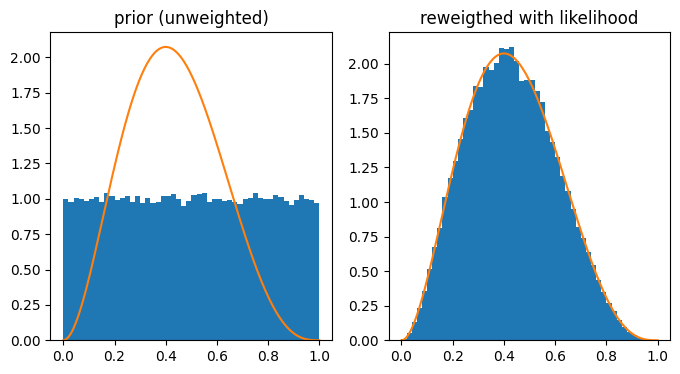

In [28]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
N = 100000

proposal = dist.Uniform(0,1) # prior
proposal_sample = proposal.sample((N,))
ps = torch.linspace(0,1,200)
axs[0].hist(proposal_sample, density=True, bins=50)
axs[0].plot(ps, posterior.log_prob(ps).exp())
axs[0].set_title("prior (unweighted)")

weights = torch.hstack([likelihood(xs, proposal_sample[i]) for i in range(N)])

axs[1].hist(proposal_sample, density=True, bins=50, weights=weights)
axs[1].plot(ps, posterior.log_prob(ps).exp())
axs[1].set_title("reweigthed with likelihood")

plt.savefig("lecture_2_figs/likelihood_weighting.png")

In [29]:
def coin_model(xs):
    p = sample("p", dist.Uniform(0,1))
    for i in range(len(xs)):
        sample(f"x[{i}]", dist.Bernoulli(p), observed=xs[i])
        
torch.manual_seed(0)
ctx = Trace()
with ctx:
    x = coin_model(xs)
ctx.trace 

{'p': {'value': tensor(0.4963),
  'distribution': Uniform(low: 0.0, high: 1.0),
  'is_observed': False,
  'log_prob': tensor(0.)},
 'x[0]': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.49625658988952637, logits: -0.014973938465118408),
  'is_observed': True,
  'log_prob': tensor(-0.6857)},
 'x[1]': {'value': tensor(1.),
  'distribution': Bernoulli(probs: 0.49625658988952637, logits: -0.014973938465118408),
  'is_observed': True,
  'log_prob': tensor(-0.7007)},
 'x[2]': {'value': tensor(1.),
  'distribution': Bernoulli(probs: 0.49625658988952637, logits: -0.014973938465118408),
  'is_observed': True,
  'log_prob': tensor(-0.7007)},
 'x[3]': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.49625658988952637, logits: -0.014973938465118408),
  'is_observed': True,
  'log_prob': tensor(-0.6857)},
 'x[4]': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.49625658988952637, logits: -0.014973938465118408),
  'is_observed': True,
  'log_prob': tensor(-0.6857)}}